In [13]:
import cobra
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import sys
sys.path.append('../../code/')
import leakage
from pathlib import Path
import matplotlib
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm


In [113]:
# Cost of synthesis

In [114]:
fn_cost_aa = exometabolites_folder / "cost_of_aa_biosynthesis.csv"
fn_cost_precursors = exometabolites_folder / "cost_of_aa_precursors.csv"

df_cost_aa = pd.read_csv(fn_cost_aa, index_col=0, skiprows=3, header = [0,1])
df_cost_precursors = pd.read_csv(fn_cost_precursors, index_col=2, skiprows=3, header =  [0, 1])

In [147]:
df_cost = df_cost_aa
# df_cost = pd.concat([df_cost_precursors, df_cost_aa])

# Get leakage


In [198]:
# Drop pyruvate. Clear outlier. Maybe because it is "actively secreted"?
# df_cost.drop("pyr", inplace = True)

In [207]:
time = 7
exometabolites_folder = Path("../../data/e_coli/")
leakage_df = leakage.get_leakage(exometabolites_folder, "ecoli", time = time, unit = '/gDW')
leakage_df.set_index("Metabolite", inplace=True)
leakage_df.drop_duplicates(inplace=True)
leakage_label = "Leakage (mM/gDW/h)"

In [208]:
leakage_list = []
total_cost_glucose = []
phosphate_bonds = []
aa_list = []

for aa, row in df_cost.iterrows():
    try:
        leak = leakage_df.loc[aa.upper(), "Leakage (mM/gDW/h)"]
    except KeyError:
        continue
    else:
        if leak>0:#0 and (leak > leakage_df.loc[aa.upper(), "Leakage std"])
            # I dicard those metabolites where 0 is included in mean+- 1 std -> Doesn't work well when log-transformed errorbar plot
            leakage_list.append(leak)
            # leakage_error.append(leakage_df.loc[aa.upper(), "Leakage std"])
            total_cost_glucose.append(row["Glucose"]["Total, ~P"])
            phosphate_bonds.append(row["Glucose"]["~P"])
            aa_list.append(aa)
leakage_arr = np.array(leakage_list)
# leakage_error = np.array(leakage_error)

In [209]:
log_leakage = np.log10(leakage_arr)
rho1, pval1 = st.pearsonr(total_cost_glucose, log_leakage)

X = sm.add_constant(total_cost_glucose)
mod = sm.OLS(log_leakage, X)
res = mod.fit()
res.summary()


/Users/ssulheim/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     5.259
Date:                Tue, 11 Apr 2023   Prob (F-statistic):             0.0448
Time:                        20:03:20   Log-Likelihood:                -4.6489
No. Observations:                  12   AIC:                             13.30
Df Residuals:                      10   BIC:                             14.27
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3618      0.203     -6.700      0.000      -1.815      -0.909
x1            -0.0155      0.007     -2.293      0.045      -0.031      -0.000
==============================================================================
Omnibus:                        0.524   Durbin-Watson:                   2.362
Prob(Omnibus):                  0.769   Jarque-Bera (JB):                0.563
Skew:                           0.351   Prob(JB):                        0.755
Kurtosis:                       2.204   Cond. No.                         54.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [210]:
log_leakage = np.log10(leakage_arr)
rho2, pval2 = st.pearsonr(phosphate_bonds, log_leakage)

X = sm.add_constant(phosphate_bonds)
mod = sm.OLS(log_leakage, X)
res = mod.fit()
res.summary()


/Users/ssulheim/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     8.501
Date:                Tue, 11 Apr 2023   Prob (F-statistic):             0.0154
Time:                        20:03:20   Log-Likelihood:                -3.4930
No. Observations:                  12   AIC:                             10.99
Df Residuals:                      10   BIC:                             11.96
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4945      0.135    -11.097      0.000      -1.795      -1.194
x1            -0.0528      0.018     -2.916      0.015      -0.093      -0.012
==============================================================================
Omnibus:                        0.880   Durbin-Watson:                   2.387
Prob(Omnibus):                  0.644   Jarque-Bera (JB):                0.684
Skew:                           0.503   Prob(JB):                        0.710
Kurtosis:                       2.403   Cond. No.                         9.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [211]:
df_pb = pd.DataFrame()
df_pb["log10(Leakage (mM/gDW/h))"] = log_leakage
df_pb["Total energy cost, ~P"] = total_cost_glucose


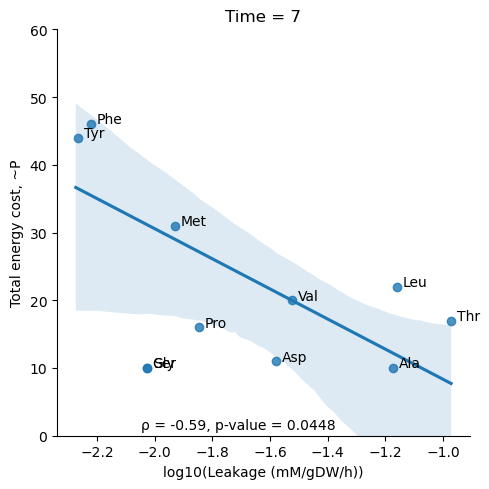

In [212]:
# fig, ax  = plt.subplots(1)
fg = sns.lmplot(data = df_pb, x = "log10(Leakage (mM/gDW/h))", y = "Total energy cost, ~P")
for l, p, aa in zip(log_leakage, total_cost_glucose, aa_list):
    fg.axes[0,0].annotate(aa, (l+0.02, p+0.1))
fg.axes[0,0].set_ylim(0, 60)
fg.axes[0,0].annotate('ρ = {0:.2f}, p-value = {1:.4f}'.format(rho1, pval1), (np.min(log_leakage)*0.9, 1))
fg.axes[0,0].set_title('Time = {0}'.format(time))
plt.tight_layout()
plt.savefig('leakage_vs_cost_AA_time_{0}.pdf'.format(time))
plt.show()

In [213]:
phosphate_bonds

[0, 1, 10, 2, 0, 9, 2, 2, 3, 0, 19, 10]

In [214]:
leakage_df

,Leakage (mM/gDW/h)
Metabolite,
G6P,1.424501
F6P,2.818145
FBP,2.098847
DHAP,2.168361
GA3P,0.909586
23PG,0.862645
PEP,0.177739
R5P,0.256798
RU5P+X5P,0.132057
